# Image Classifier Fundamentals

To establish fundamentals, first a set of utilities necessary for image preprocessing and loading from the disk. Then we will use the k-Nearest Neighbor (k-NN) classifier to recognize image class labels using only the raw pixel intensities.

## Dataset: "Animals"

The "Animals" dataset is a simple dataset pieced together by Adrian Rosebrock to reveal the process of training an image classifier using different machine learning techniques. The dataset consists of three class labels, (1) dogs, (2) cats, and (3) pandas. Each class label has exactly 1,000 images, totaling in 3,000 images. The images within the dataset are actually subsets of both the Kaggle "[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats)" challenge and the [ImageNet](https://www.image-net.org/) dataset. 

## Utilities
**Image Preprocessor**

Images are required to be preprocessed and scaled to have identical widths and heights suitable for machine learning algorithms. Though image preprocessing can take many forms in resizing, scaling, or respect of aspect ratio, this image preprocessor will only resize images and ignore aspect ratio.

In [1]:
# import necessary packages
import cv2

class SimplePreprocessor:
    def __init__(self, width, height, inter = cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter
        
    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect ratio
        return cv2.resize(image, (self.width, self.height), interpolation = self.inter)

The imported packaged needed for our image preprocessor is cv2, otherwise known as OpenCV.

Following library imports, the constructor is seen with three arguments.
- *width*: Required, the desired width of the input image after resizing.
- *height*: Required, the desired height of our input image after resizing. 
- *inter*: Optional, choice of interpolation algorithm when resizing.

The *preprocess* function accepts a single input ad returns the desired processed image. 

**Image Loader**

In [2]:
# import the necessary packages packages
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
    def __init__(self, preprocessors = None):
        # store the image preprocessor
        self.preprocessors = preprocessors
        
        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None: 
            self.preprocessors = []
        
    def load(self, imagePaths, verbose = -1):
        # initialize the list of features and labels
        data = []
        labels = []
        
        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
            
            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over preprocessors and apply each to the image
                for p in self.preprocessors:
                    image = p.preprocess(image)
                    
            # treat our processed image as a 'feature vector'
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)
            
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))
                
        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

The following library packages are imported:
- *numpy* - for numerical processing
- *cv2* - for OpenCV bindings
- *os* - to extract names of subdirectories in image paths

The constructor has one optional argument, *preprocessors*, in which a list of desired preprocessors can be inputed to process images accordingly. The input type being a list is important to being able to perform sequential modifications, such as resizing an image first and then scaling the resized image. 

The *load* function requires one argument, *imagePaths*, referring to the location of the dataset within the disk. Verbose refers to viewing the active updates taking place while the function is performing its objective. The *data* and *labels* variables begin an empty list in which to store the data we will iterate through given that *preprocessors* is not equal to *None*. 

## k-Nearest Neighbors (k-NN)

The k-NN algorithm is simple enough in which no 'learning' is actually taking place. Rather, k-NN is dependent on the distance feature vectors (RGB pixel intensities). That is, the algorithm classifies data points by finding the most common class among *k* closest 'points'. Whichever label has the most data points closest to the image of interest is considered the most likely label. The underlying assumption is images with the same class label will share similar characteristics between different images (i.e., data points), and this will be seen when expressed as a feature vector. 

We will use four steps to train a k-NN algorithm to classify the *animals* dataset based on the raw pixel intensities of images. 

1. Gather Dataset - Each image of the 'animals' dataset will be preprocessed using our SimplePreprocessor.
2. Split Dataset - The dataset will be split into a training and testing set. 
3. Train Classifier - The k-NN classifier will be trained on the training dataset. 
4. Evaluate - The k-NNs performance will be evaluated on the test set. 

In [15]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

# grab the list of images that we'll be describing
print("[INFO] loading images...")

imagePaths = list(paths.list_images('datasets//animals'))

# initialize the image preprocessor, load the data from disk and reshape the data matrix
sp = SimplePreprocessor(32,32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data,labels) = sdl.load(imagePaths, verbose = 1000)
data = data.reshape((data.shape[0], 3072))

# show information on memory consumption of the images
print("[INFO] features matrix: {:.1f}MB".format(data.nbytes / (1024 * 1024.0)))

[INFO] loading images...
[INFO] processed 1000/3000
[INFO] processed 2000/3000
[INFO] processed 3000/3000
[INFO] features matrix: 8.8MB


Imported Library Packages
- KNeighborsClassifier: implements the k-NN algorithm
- LabelEncoder: converts labels represented as strings into unique integers per class
- train_test_split: function to help create a training and test set
- classification_report: utility function to help evaluate performance

________

*imagePaths* is used to store the file paths to all the images in the 'animals' dataset. Afterwards, *SimplePreprocessor* is initialized to resize images to 32x32 pixels. Next *SimpleDatasetLoader* is with our *SimplePreprocessor* as it's preprocessor in order to return both the image and it's correponding label.

Because our data's shape is originally a numpy array of (3,000, 32, 32, 3), we will 'flatten' the three-dimensional array into a single list that a k-NN algorithm can understand. 

In [35]:
# encode the labels as integers 
le = LabelEncoder()
labels = le.fit_transform(labels)

# partition the data into training and testing splits using 75% of the data for training and 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.25, random_state = 42)

*labels* is originally represent as just a list of strings, therefore to create 'categories' or classes, we use the LabelEncoder function to convert these strings into integers. Afterwards the data is partitioned into a training and test set.

In [43]:
# train and evaluate a k-NN classifier on the raw pixel intensities 
print("[INFO] evaluating k-NN classifier...")

model = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
model.fit(trainX, trainY)

print(classification_report(testY, model.predict(testX)))

[INFO] evaluating k-NN classifier...
              precision    recall  f1-score   support

           0       0.41      0.77      0.54       262
           1       0.35      0.31      0.33       249
           2       0.88      0.15      0.26       239

    accuracy                           0.42       750
   macro avg       0.55      0.41      0.38       750
weighted avg       0.54      0.42      0.38       750



In [44]:
# train and evaluate a k-NN classifier on the raw pixel intensities 
print("[INFO] evaluating k-NN classifier...")

model = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
model.fit(trainX, trainY)

print(classification_report(testY, model.predict(testX)))

[INFO] evaluating k-NN classifier...
              precision    recall  f1-score   support

           0       0.42      0.61      0.50       262
           1       0.39      0.47      0.42       249
           2       0.91      0.27      0.41       239

    accuracy                           0.45       750
   macro avg       0.57      0.45      0.44       750
weighted avg       0.57      0.45      0.45       750



**Results**

Two k-NN classifiers were conducted. The first k-NN classifier measuring the closest 2 images based on raw pixel intensity and the second k-NN classifier based on the closest 5 images. We see that our k-NN classifier performs better when taking into account the closest 5 images based on raw pixel intensity. 

## Downside to k-NN

The issue with k-NN classifier is that there is no 'actual' learning taking place, only training of data within a model to make predictions that will be compared to ground truth data. If attempting to scale, the k-NN classifier would be inefficient in that a large dataset would proove restrictive. In addition, an exact copy of the data needs to be stored within the model in order to successfully perform a k-NN classification. 

## Parameterized Learning

Due to the impracticality of some algorithms, like the k-NN classifier, other methods are more desirable for larger datasets. Therefore, machine learning models that can discover patterns from input data are used. These machine learning models are benefitted by recognizing vital parameters in data. Parameters are established by using *data*, *scoring functions*, *loss functions*, and *weights and biases*.

- Data - the input data encompassing the data points and their respective class labels.
- Scoring Functions - application of a selected 'function' in which predicted class labels are returned. 
- Loss Function - function determining how well the *predicted values* compare to the *true values*.
- Weights & Biases - often referred to as the parameters.

### Example - Linear Classification

[INFO] dog: 7963.93
[INFO] cat: -2930.99
[INFO] panda: 3362.47


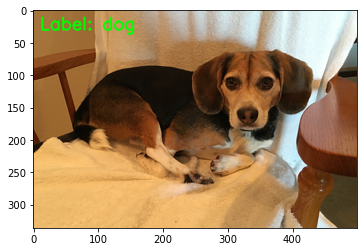

In [18]:
# import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt

# initialize class labels and set the seed of the pseudorandom number generator to reproduce results
labels = ["dog", "cat", "panda"]
np.random.seed(1)

# randomly initialize weights and bias for demonstrations purposes
W = np.random.randn(3,3072)
b = np.random.randn(3)

# load example image, then resize and flatten into a "feature vector"
orig_image = cv2.imread("datasets/beagle.png")
image = cv2.resize(orig_image, (32,32)).flatten()

# calculate the output scores using the standard formula for linear classification
# Wx_i + b
scores = W.dot(image) + b

# loop over scores and labels
for (label,score) in zip(labels, scores):
    print("[INFO] {}: {:.2f}".format(label,score))
    
# place label with highest prediction on image
cv2.putText(orig_image, "Label: {}".format(labels[np.argmax(scores)]),
           (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# display input image
#cv2.imshow("Image", orig_image)
#cv2.waitKey(0)

# save image to show result within jupyter notebook
#file_path = r"C:\Users\chris\Desktop\Projects\ComputerVision\1_ImageClassifierFundamentals"
cv2.imwrite("Image.png", orig_image)
cv2.waitKey(0)

img = cv2.imread('Image.png')[:,:,::-1]
plt.imshow(img);

The dog class had the largest scoring *function value* of 7963.93, suggesting the "dog" class will be chosen by the classifier.

## Optimization and Regularization

Optimization algorithms are the engines that power neural networks and enable themto learn patterns from data. **But how we go aout *finding* and *obtaining* a weight matrix *W* and bias vector *b*?** We need to define an *optimization algarithm* that allows us to *literally improve W* and **and** *b*. We'll be looking at the mot common algorithm used to rain neural networks and deep learning model - *gradient descent*. Gradient descent has many variants, but, in each case, the idea is the same: iteratively evalutate your parameters, compute your loss, then take a small step in the direction that will minimize your loss.

### Gradient Descent

The gradient descent algorithm has two primary flavors:
1. The standard 'vanilla' implementation.
2. The optimized 'stochastic' version that is more commonly used. 

We'll be reviewing the basic vanilla implemention.

The gradient descent method is an *iterative optimization algorithm* that operates over a **loss landscape** (also called an *optimization surface*). 

For the sake of this discussion, simply internatilize what gradient descent is: attempting to optimize our parameters for low loss and high classification accuracy via an iterative process of taking a step in the direction that minimizes loss.

### Implementing Basic Gradient Descent in Python

In [1]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

def sigmoid_activation(x):
    # compute the sigmoid activation value for a given input
    return 1.0 /(1 + np.exp(-x))

def sigmoid_deriv(x):
    # compute the derivative of the sigmoid function ASSUMING
    # that the input 'x' has already been
    # activation function
    return x * (1-x)

def predict(X, W):
    # take the dot product between our features and weight matrix
    preds = sigmoid_activation(X.dot(W))
    # apply a step function to threshold the outputs to binary class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1
    
    # return the predictions
    return preds

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("e", "--epochs", type = float, default = 0.01,
               help = "learning rate")
args = vars(ap.parse_args())

# generate a 2-class classification problem with 1,000 data points
# where each data point is a 2D feature vector
(X,y) = make_blobs(n_samples = 1000, n_features = 2, centers = 2,
                  cluster_std = 1.5, random_state = 1)
y = y.reshape((y.shape[0],1))

# insert a column of 1's as the last entry in the feature matrix -- this little trick
# allows us to treat the bias as a trainable parameter within the weight matrix
X = np.c_[X, np.ones((X.shape[0]))]

# partition the data into training and testing splits using 50% of the data for training
# and the remaining 50% for testing
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.5, random_state = 42)

# initialize our weight matrix and list of losses
print("[INFO] training...")
W = np.randn(X.shape[1], 1)
losses = []

# loop over the desired number of epochs
for epoch in np.arange(0, args["epochs"]):
    # take the dot product between our features 'X' and the weight matrix
    # 'W', then pass this alue through our sigmoid activation function, 
    # thereby giving us our predictions on the dataset
    preds = sigmoid_activation(trainX.dot(W))
    
    # now that we have our predictions, we need to determine the 'error', which is the difference between our predictions 
    # and true values
    error = preds - trainY
    loss = np.sum(error ** 2)
    losses.append(loss)
    
    # the gradient descent update is the dot product between our (1) features and (2) the error of the 
    # sigmoid derivative of our predictions 
    d = error * sigmoid_deriv(preds)
    gradient = trainX.T.dot(d)
    
    # in the updae stage, all we need to do is 'nudge' the weight matrix in the negative direction of the gradient
    # (hence the term "gradient descent" by taking a small step towards a set of "more optimal" parameters)
    W += -args["alpha"] * gradient
    
    # check to see if an update should be displayed
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print("[INFO] epoch = {}, loss = {:.7f}".format(int(epoch + 1), loss))
        
# evaluate our model
print("[INFO] evaluating...")
preds = predict(testX, W)
print(classification_report(testY, preds))

# plot the (testing) classification data
plt.style.use("ggplot")
plt.figure()
plt.title("Data")
plt.scatter(testX[:, 0], testX[:, 1], marker = 'o', c=testY[:, ], s = 30)

# construct a figure that plots the loss over time
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), losses)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

NameError: name 'argparse' is not defined

[INFO] training...
[INFO] epoch = 1, loss = 245.9009539
[INFO] epoch = 5, loss = 240.9085756
[INFO] epoch = 10, loss = 204.5837348
[INFO] epoch = 15, loss = 3.5790859
[INFO] epoch = 20, loss = 1.4410021
[INFO] epoch = 25, loss = 0.7461957
[INFO] epoch = 30, loss = 0.4914118
[INFO] epoch = 35, loss = 0.3714114
[INFO] epoch = 40, loss = 0.3045629
[INFO] epoch = 45, loss = 0.2634921
[INFO] epoch = 50, loss = 0.2368039
[INFO] epoch = 55, loss = 0.2188706
[INFO] epoch = 60, loss = 0.2065118
[INFO] epoch = 65, loss = 0.1977525
[INFO] epoch = 70, loss = 0.1913063
[INFO] epoch = 75, loss = 0.1863290
[INFO] epoch = 80, loss = 0.1822763
[INFO] epoch = 85, loss = 0.1788075
[INFO] epoch = 90, loss = 0.1757148
[INFO] epoch = 95, loss = 0.1728742
[INFO] epoch = 100, loss = 0.1702124
[INFO] evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

    accuracy                       

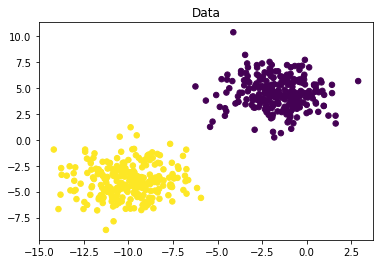

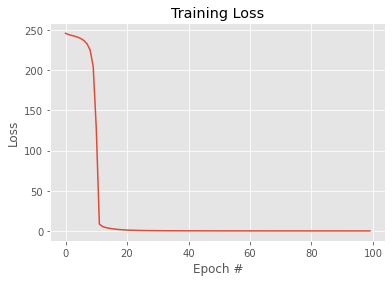

In [1]:
# import necessary packages 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np 
import argparse

def sigmoid_activation(x):
    # compute the sigmoid activation value for a given input
    return 1.0 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    # compute the derivative of the sigmoid funcion ASSUMING
    # that the input 'x' has already been passed through the sigmoid 
    # activation function
    return x * (1 - x)

def predict(X, W):
    # take the dot product between our features and weight matrix
    preds = sigmoid_activation(X.dot(W))
    
    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1
    
    # return the predictions
    return preds

# generate a 2-class classification problem with 1,000 data points,
# where each data point is a 2D feature vector
(X, y) = make_blobs(n_samples=1000, n_features = 2, centers = 2, 
                    cluster_std = 1.5, random_state = 1)
y = y.reshape((y.shape[0], 1))

# insert a column of 1's as the last entry in the feature 
# matrix -- this little trick allows us to treat the bias 
# as a trainable parameter within the weight matrix
X = np.c_[X, np.ones((X.shape[0]))]

# partition the data into training and testing splits using 50% of 
# the data for training and the remaining 50% for testing
(trainX, testX, trainY, testY) = train_test_split(X, y,
                                                 test_size = 0.5, random_state = 42)

# initialize our weight matrix and list of losses
print("[INFO] training...")
W = np.random.randn(X.shape[1], 1)
losses = []

# loop over the desired number of epochs
for epoch in np.arange(0, 100):
    # take the dot product between our features 'X' and the weight
    # matrix 'W', then pass this value through our sigmoid activation
    # function, thereby giving us our predictions on the dataset
    preds = sigmoid_activation(trainX.dot(W))
    
    # now that we have our predictions, we need to determine the 
    # 'error', which is the difference between our predictions and the true values
    error = preds - trainY
    loss = np.sum(error ** 2)
    losses.append(loss)
    
    # the gradient descent update is the dot product between our 
    # (1) features and (2) the error of the sigmoid derivative of our predictions
    d = error * sigmoid_deriv(preds)
    gradient = trainX.T.dot(d)
    
    # in the update stage, all we need to do is "nudge" the weight 
    # matrix in the negative direction of the gradient (hence the
    # term "gradient descent") by taking a small step towards a set 
    # of "more optimal" parameters)
    W += -0.01 * gradient
    
    # check to see if an update should be displayed
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print("[INFO] epoch = {}, loss = {:.7f}".format(int(epoch + 1),
                                                       loss))
        
# evaluate our model
print("[INFO] evaluating...")
preds = predict(testX, W)
print(classification_report(testY, preds))

# plot the (testing) classification data
plt.figure()
plt.title("Data")
plt.scatter(testX[:, 0], testX[:, 1], marker = 'o', c = testY[:, 0], s = 30)

# compute a figure that computes loss over time
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), losses)
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

**Lines 2-7** import our required Python packages. We have seen all of these imports before, with the exception of _make_blobs_, a function used to create "blobs" of normally distributed data points -- this is a handy function when testing or implementing our own models from scratch.

We then define the *sigmoid_activation* function on **Line 9**. This is often referred to as an **_activation function_** because the function will "activate" and fine "ON" (output value > 0.5) of "OFF" (output value <= 0.5) based on the inputs of *x*.

**Lines 13-17** define the *derivative* of the sigmoid function. We need to compute the derivative of this function to derive the actual gradient. The gradient is what enables us to travel down the slope the optimization surface. 

The **_prediction function**_ applies our sigmoid activation function and then thesholds it based on whether the neuron is firing (1) or not (0).

Given a set of input data points *X* and weights *W*, we call the **_sigmoid activation_** function on them to obtain a set of predictions (**Lines 21**). We then threshold the predictions: any prediction with a value <= 0.5 is set to 0 while any prediction with a value <= 0.5 is set to 0 while any prediction with a value > 0.5 is set to 1 (**Lines 25 and 26**). The predictions are then returned to the calling function on **Line 29**.

On **Line 33** we make a call to *make_blobs* which generates 1,000 data points separated into two classes. These data points are 2D, implying that the "feature vectors" are of length 2. The labels for each of these data points are either *0* or *1*. Our goal is to train a classifier that correctly predicts the class label for each data point.

**Line 40** applies the "bias trick" (detailed above) that allows us to skip *explicitly* keeping track of our bias vector *b*, by inserting a brand new column of 1's as the last entry in our design matrix *X*. Adding a column containing a constant value acrosss *all* feature vectors allows us to treat our bias a a *trainable parameter* **_within_** the weight matrix *W* rather than as an entirely separate variable.

The next code block handles randomly initializing our weight matrix using a uniform distribution such that it has the same number of dimensions as our input features (including the bias). Initialization is **_critical_** to training a neural network in a reasonable amount of time. **Line 50** initializes a list to keep track of our losses ater each epoch. At the end, we'll plot the loss (which should ideally decrease over time).

Then we move onto actual training and gradient descent. In **Line 53** we start looping over the supplied number of *epochs*. Then, **Line 57** takes the dot product between our *entire* training set **trainX** and our weight matrix **W**. The output of his dot product is fed through the sigmoid activation function, yielding our predictions. 

Given our predictions, the next step is to determine the "error" of the predictions. **Line 63** computes the least squares error over our predictions, a simple loss typically used for binary classification problems. The goal of this training procedure is to minimize our least squares error. We append this *loss* to our *losses* list, so we can later plot the loss over time. 

We then computer the *gradient* and then use it to update our weight matrix *W*.

**Line 74** is the most critical step i our algorithm and where the actual gradient descent takes place. Here we update our weight matrix *W* by taking a tep in the negative direction of the gradient. After updating our weight matrix, we check to see if an update should be displaued to our terminal and then keep looping until the desired number of epochs has been met - gradient descent is thus an *iterative algorithm*.

The next step is is evaluation. To actually make predictions using our weight matrix *W*, we call the *predict* method on *testX* and *W* on **Line 83**. Given the predictions, we display a nicely formatted classification report. 

The last code block simply handles visualization of of the dataset over time.  

As can be seen in both the scatter plot and line graph, our dataset is linearly seperable (i.e., we can draw a line that separates teh two classes of data). Our loss also drops dramatically, starting out very high and then quickly dropping (right). We can see just how quickly the loss drops by investigating the terminal output above.

## Stochastic Gradient Descent (SGD)

As we discussed gradient descent, a first-order optimization algorithm that can be used to learn a set of classifier weights for parameterized learning. However, this "vanilla" implementation of gradient descent can be prohibitively slow to run on large datasets - in fact, it can even be considered *computational wasteful*.

Instead, we should apply **Stochastic Gradient Descent (SGD)**, a simple modification to the standard gradient descent algorithm that *computes the gradient* and *updates the weight matrix W* on **small batches of training data**, rather than the entire training set. While this modification leads to "more noisy" updates, it also allows us to take *more steps along the gradient* (one step per each batch verses one step per epoch), ultimately leader to a faster convergence and no negative effects to loss and classification accuracy.

### Mini-batch SGD

Reviewing the vanilla gradient descent algorithm, it should be (somewhat) obvious that the method will run *very slowly* on large datasets. The reason for this slowness is because each iteration of gradient descent requires us to compute a prediction for each training point in ou training data *before* we are allowed to update our weight matrix. 

**Instead, what we should do is _batch_ updates.** Updating the previous code to transform vanilla gradient descent to become SGD by adding an extra function call:

In [ ]:
#while True:
#    batch = next_training_batch(data, 256)
#    Wgradient = evaluate_gradient(loss, batch, W)
#    W += -alpha * Wgradient

The only difference between vanilla gradient descent and SGD is the addition of the *next_training_batch* function. Instead of computing our gradient descent over the entire dataset, we instead sample our data, yielding a *batch*. We evaluate the gradient on the *batch*, and update our weight matrix *W*. From an implementation perspective, we also try to randomize our training samples *before* applying SGD since the algorithm is sensitive to batches.

After looking at the pseudocode for SGD, we immediately notice an introduction of a new parameter: **_the batch size_**. Typical batch sizes include 32, 64, 128, 256. This is because both (a) batch sizes > 1 reduce variance in the parameter update, leading to a more stable convergence and (b) powers of two are often desirable for batch sizes as they allow internal linear algebra optimization libraries to be more efficient. 

### Implementing Mini-batch SGD

[INFO] training...
[INFO] epoch = 1, loss = 0.9329993
[INFO] epoch = 5, loss = 0.0616321
[INFO] epoch = 10, loss = 0.0456419
[INFO] epoch = 15, loss = 0.0375768
[INFO] epoch = 20, loss = 0.0324721
[INFO] epoch = 25, loss = 0.0288780
[INFO] epoch = 30, loss = 0.0261819
[INFO] epoch = 35, loss = 0.0240707
[INFO] epoch = 40, loss = 0.0223650
[INFO] epoch = 45, loss = 0.0209529
[INFO] epoch = 50, loss = 0.0197611
[INFO] epoch = 55, loss = 0.0187391
[INFO] epoch = 60, loss = 0.0178508
[INFO] epoch = 65, loss = 0.0170701
[INFO] epoch = 70, loss = 0.0163770
[INFO] epoch = 75, loss = 0.0157565
[INFO] epoch = 80, loss = 0.0151968
[INFO] epoch = 85, loss = 0.0146886
[INFO] epoch = 90, loss = 0.0142244
[INFO] epoch = 95, loss = 0.0137982
[INFO] epoch = 100, loss = 0.0134049
[INFO] epoch = 105, loss = 0.0130404
[INFO] epoch = 110, loss = 0.0127013
[INFO] epoch = 115, loss = 0.0123848
[INFO] epoch = 120, loss = 0.0120882
[INFO] epoch = 125, loss = 0.0118097
[INFO] epoch = 130, loss = 0.0115472
[INF

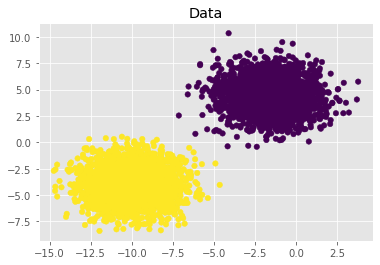

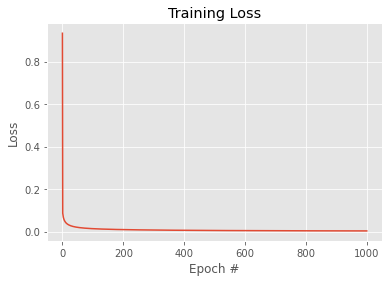

In [9]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

def sigmoid_activation(x):
    # compute the sigmoid activation value for a given input
    return 1.0 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    # compute the derivative of the sigmoid function ASSUMING 
    # that the input 'x' has already been passed through the sigmoid
    # activation function
    return x * (1 - x)

def predict(X, W):
    # take the dot product between our features and weight matrix
    preds = sigmoid_activation(X.dot(W))
    
    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1
    
    # return the predictions
    return preds

def next_batch(X, y, batchSize):
    # loop over our dataset 'X' in mini-batches, yielding a tuple of
    # the current batched data and labels
    for i in np.arange(0, X.shape[0], batchSize):
        yield (X[i:i + batchSize], y[i:i + batchSize])
        
# generate a 2-class classification problem with 10,000 data points,
# where each data point is a 2D feature vector
(X,y) = make_blobs(n_samples = 10000, n_features = 2, centers = 2,
                   cluster_std = 1.5, random_state = 1)
y = y.reshape((y.shape[0], 1))

# insert a column of 1's as the last entry in the feature 
# matrix -- this little trick allows us to treat the bias 
# as a trainable parameter within the weight matrix
X = np.c_[X, np.ones((X.shape[0]))]

# partition the data into training and testing splits using 50% of
# the data for training and the remaining 50% for testing
(trainX, testX, trainY, testY) = train_test_split(X, y,
                                                 test_size = 0.5, random_state = 42)

# initialize our weight matrix and list of losses
print("[INFO] training...")
W = np.random.randn(X.shape[1], 1)
losses = []

# loop over the desired number of epochs
for epoch in np.arange(0, 1000):
    # initialize the total loss for the epoch
    epochLoss = []
    
    # loop over our data in batches
    for (batchX, batchY) in next_batch(trainX, trainY, 64): # 64 is the batch size
        # take the dot product between our current batch of features
        # and the weight matrix, then pass this value through our 
        # activation function
        preds = sigmoid_activation(batchX.dot(W))

        # now that we have our predictions, we need to determine the 
        # 'error', which is the difference between our predictions
        # and the truel values
        error = preds - batchY
        epochLoss.append(np.sum(error ** 2))

        # the gradient descent update is the dot product between our 
        # (1) current batch and (2) the error of the sigmoid 
        # derivative of our predictions
        d = error * sigmoid_deriv(preds)
        gradient = batchX.T.dot(d)

        # in the update stage, all we need to do is "nudge" the 
        # weight matrix in the negative direction of the gradient
        # (hence the term "gradient descent") by taking a small step
        # towards a set of "more optimal" parameters
        W += -0.05 * gradient # 0.05 is the alpha value he have chosen
        
    # update our loss history by taking the average loss across all 
    # batches
    loss = np.average(epochLoss)
    losses.append(loss)
    
    # check to see if an update should be displayed
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print("[INFO] epoch = {}, loss = {:.7f}".format(int(epoch + 1),
                                                       loss))

# evaluate our model
print("[INFO] evaluating...")
preds = predict(testX, W)
print(classification_report(testY, preds))

# plot the (testing) classification data
plt.style.use("ggplot")
plt.figure()
plt.title("Data")
plt.scatter(testX[:, 0], testX[:, 1], marker = "o", c = testY[:, 0], s = 30)

# construct a figure that plots loss over time
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 1000), losses) # 1000 is number of epochs
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()  

## Regularization

How do we go about choosing a set of parameters that help ensure our model generalizes well? Or, at the very least, lessen the effects of overfitting. __*The answer is regularization*__. There are various types of regularization techniques, such as L1 regularization, L2 regularization (commonly called "weight decay"), and Elastic Net, that are used by updating te loss function itself, adding an additional parameter to constrain the capacity of the model.

We also have types of regularization that can be explicitly added to the network architecture (i.e., dropout). We then have implicit forms of regularization that are applied during the training process. Examples of implicit regularization include data augmentation and early stopping.

**Regularization helps us control our model capacity**, ensuring that our models are better at making (correct) classifications on data points that they were **_not_** trained on, or **_the ability to generalize_**. If we don't apply regularization, our classifiers can easily become too complex and overfit to the training data, in which case we lose the ability to generalize to our testing data (and data points outside the testing set as well, such as new images in the wild).

However, too much regularization can be a bad thing. We can run the risk of underfitting, in which the model will perform poorly on training data and is not able to model the relationship between the input data and the output labels (because we limited model capacity too much).

